# Directed Search

This notebook takes the output of the EMA workbench's generative algorithm that searches for optimal policies within each of our selected scenarios of interest and attempts to study and filter down the discovered policies. Our goal is to come out of this notebook with a set of 50 policies for which we can test robustness.

First, we read in the many output files produced by the optimizer. Then, we filter out any policies that are strictly dominated in terms of outcome performance by other policies from the same originating scenario. Then, we calculate and plot key metrics to demonstrate that the policy search converged. Next, we will run experiments on the discovered policies under their originating scenarios to determine whether or not they satisfy constraints that we have designed to meet our Client's needs, and filter the policies accordingly. Finally, we will select a subset of 50 policies that are relatively diverse in terms of which levers they activate.

----------------------
## 0. Imports and Setup

In [1]:
from ema_workbench.em_framework.optimization import (
    ArchiveLogger, 
    to_problem,
    epsilon_nondominated
)

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
    Scenario,
    Policy,
    MultiprocessingEvaluator,
)

from ema_workbench.util import ema_logging

import pandas as pd
import numpy as np
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

from set_diversity import find_maxdiverse
import random

from sklearn import preprocessing

from scipy.spatial.distance import pdist, squareform

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

We will need `model` objects for both of our problem formulations, as the optimization was run using `A4 Only`, but to calculate metrics of constraint, we will measure the entire outcome set (`All Dikes`).

In [3]:
model_a4, planning_steps = get_model_for_problem_formulation('A4 Only')
problem_a4 = to_problem(model_a4, searchover="levers")

# Model with 13 outcomes, neccesary to apply the constraits
model_all, planning_steps = get_model_for_problem_formulation('All Dikes')
problem_all = to_problem(model_all, searchover="levers")

### Read Results

We will use the results produced by the file `optimization__seeded_fixed_scenarios.py`. In order to parse and store these results, we will also read in the scenarios for which the multi-scenario optimization was run.

In [4]:
# Read Scenarios from file
scenarios_df = pd.read_csv('./output/selected_scenarios.csv')
scenarios_df = scenarios_df.set_index('Run ID')
scenarios_df

,A0_ID_flood_wave_shape,A1_Bmax,A1_Brate,A1_pfail,A2_Bmax,A2_Brate,A2_pfail,A3_Bmax,A3_Brate,A3_pfail,A4_Bmax,A4_Brate,A4_pfail,A5_Bmax,A5_Brate,A5_pfail,discount_rate_0,discount_rate_1,discount_rate_2
Run ID,,,,,,,,,,,,,,,,,,,
54840,20,105.319201,10.0,0.372764,290.549630,1.0,0.142059,144.741105,1.0,0.713041,184.297098,10.0,0.029110,83.390052,10.0,0.320759,1.5,1.5,2.5
91325,74,241.014674,1.0,0.427786,141.518951,1.5,0.135387,33.712850,1.0,0.519517,251.142303,1.0,0.010708,50.644440,1.5,0.940807,2.5,1.5,4.5
74784,129,133.550281,1.5,0.933527,252.803332,10.0,0.547453,32.554365,1.0,0.711748,271.783235,10.0,0.090635,207.554354,1.0,0.596976,2.5,4.5,1.5
71789,98,245.492589,1.5,0.730879,103.700541,1.5,0.811144,212.666805,1.5,0.966618,51.327441,10.0,0.044872,285.428060,1.0,0.912670,1.5,1.5,1.5


In [5]:
# Convert Scenario IDs to a list
scenarios = [int(idx) for idx, row in scenarios_df.iterrows()]
scenarios

[54840, 91325, 74784, 71789]

In [6]:
# Read optimization output files. For each (seed, scenario) pair, there are
# 3 files to read: results and convergence (CSVs), and archives (a tarball).
# This process seeds are sequential starting at 0, but could be adapted 
# to handle arbitrary seed numbers.

results = {}
convergences = {}
archives = {}

for scenario in scenarios:
    results[scenario] = []
    convergences[scenario] = []
    archives[scenario] = []
    for seed in range(5):
        # Results and Convergences
        fn_head = './output/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.csv'

        res = pd.read_csv(fn_head + 'results' + fn_tail, index_col=0)
        results[scenario].append(res)

        conv = pd.read_csv(fn_head + 'convergence' + fn_tail, index_col=0)
        convergences[scenario].append(conv)

        # Archives
        fn_head = './archives/POLICY_SEARCH__'
        fn_tail = f'__scen{scenario}__seed{seed}.tar.gz'
        arch = ArchiveLogger.load_archives(fn_head + 'archive' + fn_tail)
        for key, df in arch.items():
            if 'Unnamed: 0' in df.columns:
                arch[key] = arch[key].drop('Unnamed: 0', axis=1)
        archives[scenario].append(arch)


-------------------
## 1. Filtering Out Pareto-Dominated Policies

Here, we can filter out any policies that are strictly worse than than other policies tested under the same scenario as them. These policies make it into the total set due to running the optimizer across 5 different seeds, and they are not useful policies to carry forward in an analysis (in a single-seed test, the generative algorithm search itself would inherently ignore such dominated policies), so we want to filter them out.

In [7]:
policy_sets = {}
epsilon = [100, 0.01, 100, 100, 0.01]
for scenario in scenarios:
    df = epsilon_nondominated(results[scenario], epsilon, problem_a4)
    policy_sets[scenario] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario} has {n_policies} non-dominated policies")

Scenario 54840 has 116 non-dominated policies
Scenario 91325 has 107 non-dominated policies
Scenario 74784 has 41 non-dominated policies
Scenario 71789 has 22 non-dominated policies


After this step, we are left with almost 300 policies to consider going forward.

---------------------

## 2. Test Convergence of Generative Algorithm

To demonstrate that we let the generative algorithm run for a sufficient number of generations to discover meaningful policies, we will plot various convergence metrics for each seed and scenario we used in our search.

In [8]:
# Calculate convergence metrics
convergence_metrics = {}
for scenario in scenarios:
    pols = policy_sets[scenario]
    hv = HypervolumeMetric(pols, problem_a4)
    gd = GenerationalDistanceMetric(pols, problem_a4, d=1)
    ei = EpsilonIndicatorMetric(pols, problem_a4)
    ig = InvertedGenerationalDistanceMetric(pols, problem_a4, d=1)
    sm = SpacingMetric(problem_a4)

    convergence_metrics[scenario] = []

    for archive in archives[scenario]:
        metrics = []
        for nfe, a in archive.items():
            scores = {
                "generational_distance": gd.calculate(a),
                "hypervolume": hv.calculate(a),
                "epsilon_indicator": ei.calculate(a),
                "inverted_gd": ig.calculate(a),
                "spacing": sm.calculate(a),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        convergence_metrics[scenario].append(metrics)

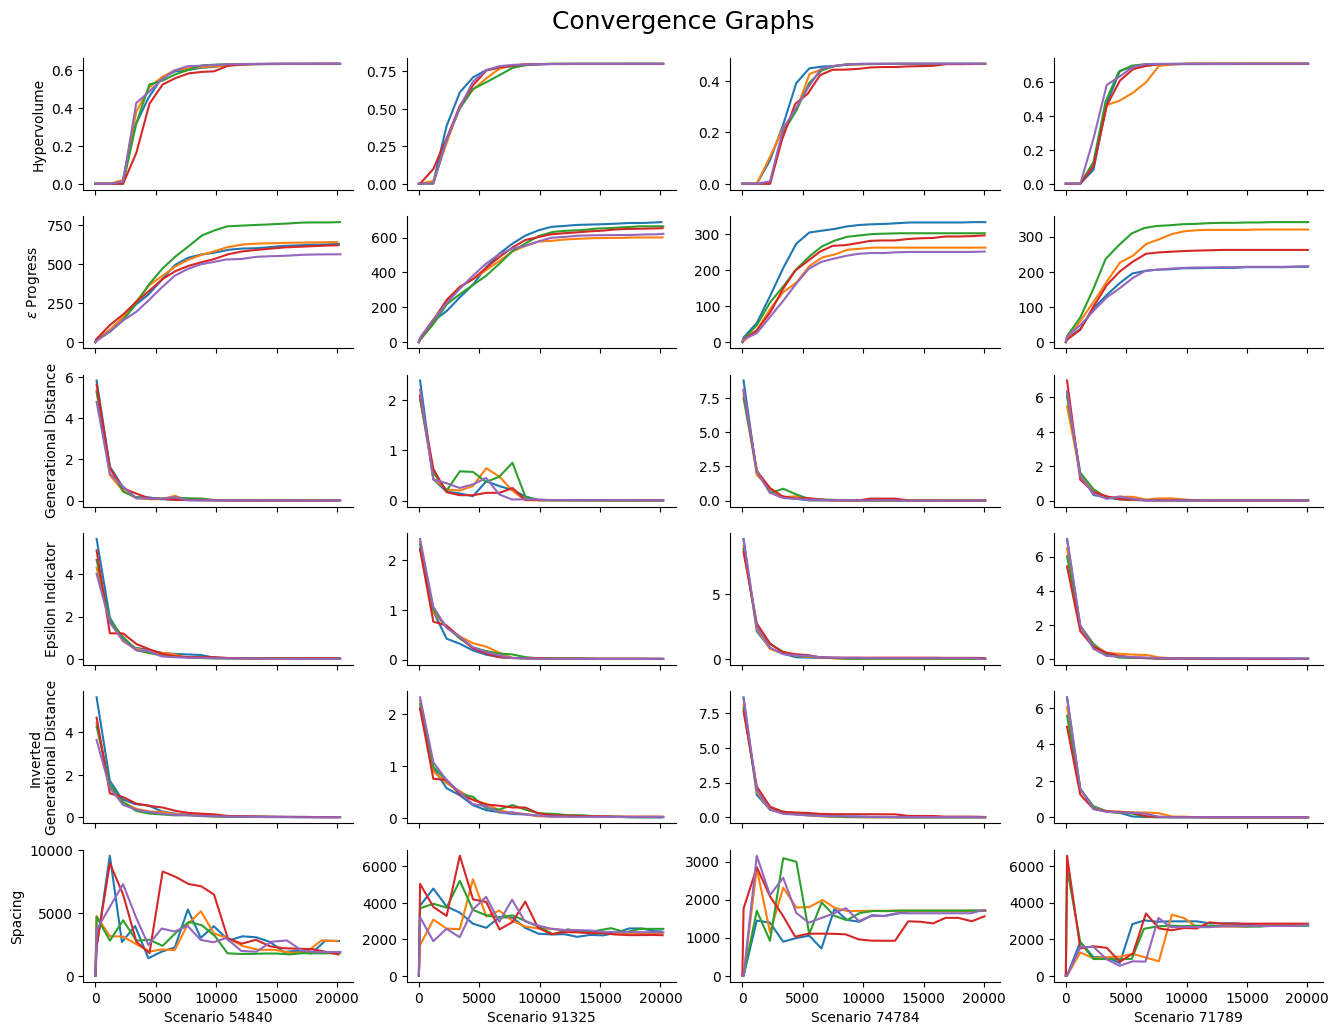

In [9]:
fig, axes = plt.subplots(nrows=6, ncols=len(scenarios), figsize=(16, 12), sharex=True)

for i, scenario in enumerate(scenarios):
    for metrics, convergence in zip(convergence_metrics[scenario],
                                    convergences[scenario]):
        axes[0][i].plot(metrics.nfe, metrics.hypervolume)

        axes[1][i].plot(convergence.nfe, convergence.epsilon_progress)

        axes[2][i].plot(metrics.nfe, metrics.generational_distance)

        axes[3][i].plot(metrics.nfe, metrics.epsilon_indicator)

        axes[4][i].plot(metrics.nfe, metrics.inverted_gd)

        axes[5][i].plot(metrics.nfe, metrics.spacing)

    # for j in range(6):
    #     axes[j][i].set

    axes[5][i].set_xlabel(f'Scenario {scenario}')

fig.suptitle(f'Convergence Graphs', fontsize=18, y=0.92)
axes[0][0].set_ylabel("Hypervolume")
axes[1][0].set_ylabel("$\epsilon$ Progress")
axes[2][0].set_ylabel("Generational Distance")
axes[3][0].set_ylabel("Epsilon Indicator")
axes[4][0].set_ylabel("Inverted\nGenerational Distance")
axes[5][0].set_ylabel("Spacing")
sns.despine(fig)
plt.savefig(f'img/convergence_graphs.png')
plt.show()

Something something interpretation @Christopher de Bruijn

----------------------------
## 3. Filter Policies by Whether They Satisfy Client-Led Constraints

From discussions with our clients, we determined several goals guiding the performance of an acceptable policy. Some of these were operationalized in the generative policy search, such as minimizing flood risk in Dike Ring 4 and across the whole IJssel River region. Others, however, must be applied as constraints. Centrally, this is the following goal, from our report:

> 6. Receive commensurate protection to those in urban areas (Dike Rings 3 & 5), and more protection than the industrial farmers in Dike Rings 1 & 2.

We operationalize this as follows:

1. The ratio of both damages and deaths in Dike Ring 4 to their respective equivalent in Dike Rings 3 & 5 must be no worse than it is in the "Do Nothing" case. at most as the one in the baseline.
2. The ratio of both damages and deaths in Dike Ring 4 to their respective equivalent in Dike Rings 1 & 2 must be no worse than 80% of its value in the "Do Nothing" case. at most as the one in the baseline.

### Generating & Running Experiments

To apply these constraints, we must first run experiments using the IJssel River model to evaluate the performance of these policies under their originating scenarios. We can construct Policy and Scenario objects for the EMA Workbench to use in running these experiments.

In [10]:
# Generate Policy objects
policies_to_evaluate = {}

for scenario in scenarios:
    policies_to_evaluate[scenario] = []

    # Capture all non-dominated policies for this scenario
    policies = policy_sets[scenario]
    for idx, policy in policies.iterrows():
        policy_name = f's{scenario}_p{idx}'
        policies_to_evaluate[scenario].append(Policy(policy_name,
                                              **policy.to_dict()))

    # Append the Do-Nothing Policy
    do_nothing = {"EWS_DaysToThreat": 0}
    for i in range(5):
        dike = "A" + str(i+1)
        do_nothing.update({f"{dike}_DikeIncrease_t{n}": 0 for n in planning_steps})
        do_nothing.update({f"rfr_{i}_t{n}": 0 for n in planning_steps})

    p_ref = Policy("Base Case", **do_nothing)
    policies_to_evaluate[scenario].append(p_ref)
    

In [11]:
# Run experiments
experiment_results = {}
for scenario in scenarios:
    # Build Scenario object
    scenario_dict = {}
    for col in scenarios_df:
        scenario_dict.update({col : scenarios_df.loc[scenario, col]})
    ema_scenario = Scenario(scenario, **scenario_dict)

    # Run Policies for current Scenario
    with MultiprocessingEvaluator(model_all) as evaluator:
        experiment_results[scenario] = evaluator.perform_experiments(ema_scenario,
                                                    policies_to_evaluate[scenario])

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 117 policies * 1 model(s) = 117 experiments
100%|████████████████████████████████████████| 117/117 [00:36<00:00,  3.23it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 108 policies * 1 model(s) = 108 experiments
100%|████████████████████████████████████████| 108/108 [00:34<00:00,  3.14it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 42 policies * 1 model(s) = 42 experiments
100%|██████████████████████████████████████████| 42/42 [00:15<00:00,  2.74it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1 scenarios * 23 policies * 1 model(s) = 23 experime

In [12]:
STRICTNESS = 1.25 # acceptability vs. Industrialized Farmers (1.25 = 1/0.8)

satisficing_policies = []
for scenario in scenarios:
    experiments, outcomes = experiment_results[scenario]
    outcomes = pd.DataFrame(outcomes)

    # Calculate ratios of interest
    outcomes['Urban Damages Ratio'] = (
        outcomes['A4_Expected_Annual_Damage']
        / (outcomes['A3_Expected_Annual_Damage']
           + outcomes['A5_Expected_Annual_Damage'])
    )

    outcomes['Urban Deaths Ratio'] = (
        outcomes['A4_Expected_Number_of_Deaths']
        / (outcomes['A3_Expected_Number_of_Deaths']
           + outcomes['A5_Expected_Number_of_Deaths'])
    )

    outcomes['Industrialized Farmers Damages Ratio'] = (
        outcomes['A4_Expected_Annual_Damage']
        / (outcomes['A1_Expected_Annual_Damage']
           + outcomes['A2_Expected_Annual_Damage'])
    )

    outcomes['Industrialized Farmers Deaths Ratio'] = (
        outcomes['A4_Expected_Number_of_Deaths']
        / (outcomes['A1_Expected_Number_of_Deaths']
           + outcomes['A2_Expected_Number_of_Deaths'])
    )
    
    # Extract the Base Case ("Do Nothing" policy)
    base_case = outcomes.iloc[len(outcomes)-1, :]
    outcomes = outcomes.iloc[:len(outcomes)-1, :]
    
    # Determine whether ratios have been exceeded
    outcomes['Urban Damages Ratio Exceeded'] = \
            np.where(outcomes['Urban Damages Ratio']
                     > base_case['Urban Damages Ratio'],
                     True,
                     False)
    outcomes['Urban Deaths Ratio Exceeded'] = \
            np.where(outcomes['Urban Deaths Ratio']
                     > base_case['Urban Deaths Ratio'],
                     True,
                     False)

    outcomes['Industrialized Farmers Damages Ratio Exceeded'] = \
            np.where(outcomes['Industrialized Farmers Damages Ratio']
                     > STRICTNESS*base_case['Industrialized Farmers Damages Ratio'],
                     True,
                     False)
    outcomes['Industrialized Farmers Deaths Ratio Exceeded'] = \
            np.where(outcomes['Industrialized Farmers Deaths Ratio']
                     > STRICTNESS*base_case['Industrialized Farmers Deaths Ratio'],
                     True,
                     False)
    
    # Keep rows that satisfy ALL constraints (all must be False)
    constraint_cols = [
        'Urban Damages Ratio Exceeded',
        'Urban Deaths Ratio Exceeded',
        'Industrialized Farmers Damages Ratio Exceeded',
        'Industrialized Farmers Deaths Ratio Exceeded'
        ]
    satisficing_policy_outcomes = outcomes[outcomes[constraint_cols].sum(axis=1) == 0]

    for idx, _ in satisficing_policy_outcomes.iterrows():
        satisficing_policies.append(policies_to_evaluate[scenario][idx])

We can now create a new DataFrame of named policies that satisfy our constraints.

In [13]:
columns = ['Policy Name'] + [key for key in satisficing_policies[0]]
policies_df = pd.DataFrame(columns=columns)

# Convert Policy objects into DataFrame rows
for i, policy in enumerate(satisficing_policies):
    row = []
    for col in columns:
        if col == 'Policy Name':
            row.append(policy.name)
        else:
            row.append(policy[col])
    policies_df.loc[i] = row

In [14]:
print(f'{policies_df.shape[0]} policies satisfy the constraints.')
policies_df.head(3)

163 policies satisfy the constraints.


,Policy Name,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,...,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,s54840_p1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.411318e+06,0.000361,5.198670e+07,7.903696e+08,0.067203
1,s54840_p2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,0.000000e+00,0.000000,1.982227e+08,0.000000e+00,0.000000
2,s54840_p3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,2.053414e+06,0.000111,1.463148e+08,9.791667e+07,0.015525


This process has cut the number of policies remaining almost in half. Though we would like to have fewer policies than this, we can use the following section to further downselect. We will save the full set to a file for completeness.

In [15]:
policies_df.to_csv('./output/policies__constraints_filtered.csv', index=False)

--------------------------

## 4. Filter for a Diverse Set of Policies

Having found the full set of discovered policies that meet our Client's requirements, we can now filter the set down to a set of 50 policies. We will do so by finding a set of 50 policies that have a relatively high diversity in terms of differences in levers: we can generate a sample of 100,000 possible sets of 50 policies, give each a lever diversity score, and select the "best" set.

In [16]:
policies_df = pd.read_csv('./output/policies__constraints_filtered.csv')

In [17]:
random.seed(1361)

# Create ID list to select policy IDs from
n_pols = policies_df.shape[0]
indices = []
for idx, row in policies_df.iterrows():
    indices.append(idx)

# Randomly create sets of 50 policies (policy IDs)
combinations = []
for _ in range(100000):
    c = random.sample(indices, 50)
    combinations.append(tuple(c))

In [18]:
# Separate the policy levers from other information captured about those policies
policies_levers = policies_df[[L.name for L in model_a4.levers]]

# Normalize each policy lever
min_max_scaler = preprocessing.MinMaxScaler()
levers_scaled = min_max_scaler.fit_transform(policies_levers)

# Calculate normalized distances within the policy sets, and assign diversity scores
distances = squareform(pdist(levers_scaled))
policy_set_diversities = find_maxdiverse(distances, combinations)
policy_set_diversities.sort(key=lambda entry:entry[0], reverse=True)


In [19]:
# Select the most diverse set (in terms of Policy IDs)
most_diverse = policy_set_diversities[0]
most_diverse_set = list(most_diverse[1])
print(most_diverse_set)
assert(len(most_diverse_set) == 50)

[21, 115, 7, 23, 154, 2, 125, 44, 80, 0, 50, 64, 61, 8, 121, 103, 18, 4, 90, 148, 43, 34, 69, 162, 67, 93, 140, 158, 41, 114, 130, 37, 113, 39, 118, 49, 102, 110, 89, 104, 52, 32, 1, 68, 147, 42, 128, 91, 22, 71]


In [20]:
# Find the policies that match these IDs
diverse_policies = policies_df.iloc[most_diverse_set]
diverse_policies.head(3)

,Policy Name,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,...,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,A5_DikeIncrease_t2,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
21,s54840_p49,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,4.832397e+07,8.049454e+08,0.068465
115,s91325_p105,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.445732e+08,0.006455,3.269490e+07,1.336630e+09,0.109680
7,s54840_p11,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.066951e+06,0.000225,8.656910e+07,4.346340e+08,0.037492


In [21]:
# Save to file
diverse_policies.to_csv('./output/policies__constraints_filtered__diverse_set_50.csv', index=False)